In [ ]:
from zumi.util.camera import Camera
from zumi.util.screen import Screen
from zumi.zumi import Zumi
import cv2
import IPython.display
import PIL.Image
import time
import math
import numpy as np
from scipy.stats import mode

screen = Screen()
zumi = Zumi()

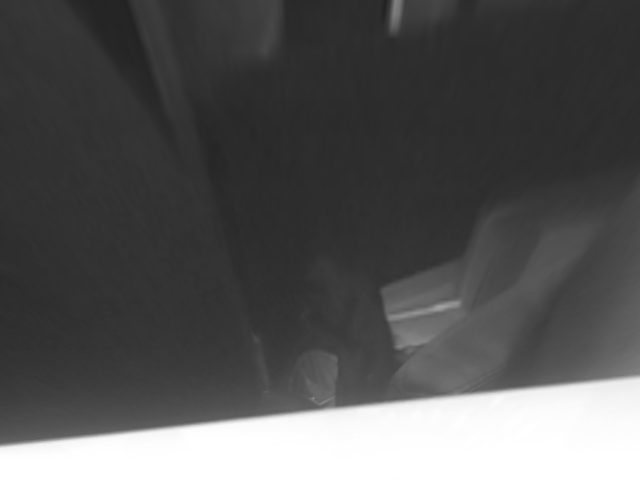

In [ ]:
%config Completer.use_jedi = False
from zumi.util.camera import Camera
from zumi.util.screen import Screen
from zumi.zumi import Zumi
import cv2
import IPython.display
import PIL.Image
import time
import math
import numpy as np
import matplotlib.pyplot as plt

screen = Screen()
zumi = Zumi()

#width = 1280
#height = 960

width = 640
height = 480

#width = 320
#height = 240

#width = 160 
#height = 120

#width = 80
#height = 60

camera = Camera(width,height)
camera.start_camera()

px_list = []

#minLineLength = 20
#maxLineGap = 15

minLineLength = 10
maxLineGap = 5

#given a list of lines
def find_avg_line_angle(lines,image):
    avg_angle = None
    if lines is not None:
        lst = []
        cnt_x_points = []
        cnt_y_points = []
        for i in range(len(lines)):
            for x1,y1,x2,y2 in lines[i-1]: 
                radians = math.atan2((x2-x1),(y2-y1))
                degrees = math.degrees(radians)
                
                #filter the angles between 70 and 110 degrees
                if degrees > 90-20 and degrees < 90+20: 
                    lst.append(degrees)
                    cv2.line(image,(x1,y1),(x2,y2),(255,255,255),1)
                    center_x_point = (x2-x1)/2
                    center_y_point = (y2-y1)/2
                    cnt_x_points.append(center_x_point)
                    cnt_y_points.append(center_y_point)                   
        if(len(lst)):
            avg_angle = sum(lst) / len(lst)    
        return avg_angle

def error_drive(error, error_threshold=0.5):
    if abs(error) > error_threshold:
        zumi.control_motors(int(error),int(-error))
        time.sleep(0.1)
        zumi.stop()
    else:
        zumi.stop() 
    
       
def warp_road(frame,width,height):
    
    top_left = [int(width/2.5),int(height*0.64)]
    top_right = [int(width - width/2.5),int(height*0.64)]
    bottom_left = [0, height]
    bottom_right = [width, height]
    
    pts1 = np.float32([top_left, top_right, bottom_left, bottom_right])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(frame, matrix, (int(width), int(height)))
    return result

def contours(frame):
    contoursArray = cv2.findContours(frame.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    # only proceed if at least one contour was found
    if len(contoursArray) > 0:
        #sort the list of contours from biggest to smallest limit it to 3
        sizeOfContourList = 3
        sortedCont = sorted(contoursArray, key=cv2.contourArea, reverse=True)[:sizeOfContourList]
        #go through all of the sorted contours and draw rectangles
        for i in range(0,len(sortedCont)):
            countour = sortedCont[i]
            x, y, w, h = cv2.boundingRect(countour)
            rectangleColor = (255, 255, 255) #(Blue,Green,Red) they go from 0-255
            #cv2.rectangle(frame, (x, y), (x + w, y + h), rectangleColor, 2)
            #cv2.rectangle(frame, (x+int(w/2), y+int(h/2)), (x + int(w/2), y + int(h/2)), (0, 0, 0) , 4)
            #cv2.putText(frame, "#:" + format(i), (int(x), int(y) + 50), cv2.FONT_HERSHEY_SIMPLEX, 0.3, rectangleColor, 1, cv2.LINE_AA)        
try: 
    while True:
        px_list  = []
        image = camera.capture() # Take a picture 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert it to gray
        warp = warp_road(gray,width,height)
        ret, black_white = cv2.threshold(warp,160,255,cv2.THRESH_BINARY) 
        
        for i in range(height):
            px_list.append(gray[int(width/2):i])
       
        edges = cv2.Canny(black_white, 50, 100)
        #edges = cv2.dilate(edges, None)
        #lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
        ret, blank_image = cv2.threshold(black_white,255,255,cv2.THRESH_BINARY)
        #avg_angle = find_avg_line_angle(lines,blank_image)
        #print(avg_angle)
        #blank_image = cv2.dilate(blank_image, None)
        #blank_image = cv2.dilate(blank_image, None)
        #contours(blank_image)
        
        #IPython.display.display(PIL.Image.fromarray(blank_image))
        #IPython.display.display(PIL.Image.fromarray(black_white))
        IPython.display.display(PIL.Image.fromarray(warp))
        IPython.display.clear_output(wait=True)       
finally:
    camera.close()
    zumi.stop()
    IPython.display.clear_output(wait=True)       